In [2]:
import os
from datetime import datetime
import logging
import textwrap
import zhinst.utils
import time 
import numpy as np
from zhinst.examples.uhfqa.common import initialize_device, acquisition_poll, ResultLoggingSource
import math
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import warnings
warnings.filterwarnings("error")
#logging.debug('This is a debug message')
#logging.info('This is an info message')
#logging.warning('This is a warning message')
#logging.error('This is an error message')
#logging.critical('This is a critical message')

def initializeDAQ(device_id):
    # Initialize connection to DAQ
    d = zhinst.ziPython.ziDiscovery()
    props = d.get(d.find(device_id))

    daq = zhinst.ziPython.ziDAQServer(props['serveraddress'],
        props['serverport'], props['apilevel'])
    daq.connectDevice(device_id, props['interfaces'][0])

    print('Device successful executed')
    return daq, device_id

def generateWeights(winType, samples, amplitude):
    ## Converted from float64 to float32 values as UHFQA will work only with single-precision values
    
    if winType == 'gaussian':
        return np.floor((2**16 * scipy.signal.windows.get_window((winType, samples/8), samples)) / 2**16) * np.float32(np.floor(2**16 * amplitude) / 2**16)
    else:
        return np.floor((2**16 * (scipy.signal.windows.get_window(winType, samples)) )/ 2**16) * np.float32(np.floor(2**16 * amplitude) / 2**16)
    
#def expectedVal(weights, path, simWave):
#        weights = weights-(0.1*path)
#        weights = np.append(weights, np.zeros(len(simWave)-len(weights)))
#        return np.sum(simWave*weights)
    
def expectedVal(weights, path, simWave, userDelay, integrationLength):
    integrationLength = math.ceil(integrationLength/4)*4
    sampleDelay = userDelay*8
    #simWave = simWave[sampleDelay:sampleDelay+integrationLength]

    weights = weights-(0.1*path)
    if(len(weights) < integrationLength):
        weights = np.append(weights, np.zeros(integrationLength-len(weights)))
    #elif(len(simWave) < integrationLength):
    #    simWave = np.append(simWave, np.zeros(integrationLength-len(simWave)))

    return np.sum(simWave*weights[:integrationLength])

def acquisition_poll(daq, paths, num_samples, timeout=10.0):
    """ Polls the UHFQA for data.

    Args:
        paths (list): list of subscribed paths
        num_samples (int): expected number of samples
        timeout (float): time in seconds before timeout Error is raised.
    """
    poll_length = 0.001  # s
    poll_timeout = 500  # ms
    poll_flags = 0
    poll_return_flat_dict = True

    # Keep list of recorded chunks of data for each subscribed path
    chunks = {p: [] for p in paths}
    gotem = {p: False for p in paths[:10]}

    # Poll data
    time = 0
    while time < timeout and not all(gotem.values()):
        dataset = daq.poll(poll_length, poll_timeout, poll_flags, poll_return_flat_dict)
        for p in paths:
            if p not in dataset:
                continue
            for v in dataset[p]:
                chunks[p].append(v['vector'])
                num_obtained = sum([len(x) for x in chunks[p]])
                if num_obtained >= num_samples:
                    gotem[p] = True
        time += poll_length

    if not all(gotem.values()):
        for p in paths:
            num_obtained = sum([len(x) for x in chunks[p]])
            print('Path {}: Got {} of {} samples'.format(p, num_obtained, num_samples))
        raise Exception('Timeout Error: Did not get all results within {:.1f} s!'.format(timeout))

    # Return dict of flattened data
    return {p: np.concatenate(v) for p, v in chunks.items()}

In [227]:
###############################################################
######################## Varying delay ########################
###############################################################

def QA_testUserDelay(daq, device, weights, userDelay):
    num_averages = 1
    result_length = 2500 # 2500 result_lengeth captures the whole square wave
    do_plot = True
    ones = 10000
    device_id = device
    integration_length = 4
    userDelay = userDelay

    # Perform initialization for UHFQA examples
    initialize_device(daq, device)

    # Configure AWG
    awg_program = textwrap.dedent("""\
    const RATE = 0;
    const FS = 1.8e9*pow(2, -RATE);
    const LENGTH = 1.0e-6;
    const N = floor(LENGTH*FS);

    wave w = join(ones(10000), -ones(10000));

    setTrigger(0);
    var loop_cnt = getUserReg(0);
    var avg_cnt = getUserReg(1);
    var wait_delta = getUserReg(2);

    var wait_time = 0;


    repeat(avg_cnt) {
      wait_time = 0;
      repeat(loop_cnt) {
        wait_time += wait_delta;
        playWave(w, w);
        wait(wait_time);
        if(wait_time == wait_delta){
          setTrigger(AWG_INTEGRATION_TRIGGER + AWG_INTEGRATION_ARM + AWG_MONITOR_TRIGGER);
        }else{
          setTrigger(AWG_INTEGRATION_TRIGGER + AWG_INTEGRATION_ARM);
        }
        setTrigger(0);
        setTrigger(AWG_INTEGRATION_ARM);
        waitWave();
        wait(1024);
      }
    }
setTrigger(0);

    """).replace('${len}', '{:d}'.format(ones))


    # Create an instance of the AWG module
    awgModule = daq.awgModule()
    awgModule.set('device', device)
    awgModule.set('index', 0)
    awgModule.execute()

    # Transfer the AWG sequence program. Compilation starts automatically.
    awgModule.set('compiler/sourcestring', awg_program)
    while awgModule.getInt('compiler/status') == -1:
        time.sleep(0.1)

    # Ensure that compilation was successful
    assert awgModule.getInt('compiler/status') != 1

    # Apply a rotation on half the channels to get the imaginary part instead
    for i in range(5):
        daq.setComplex('/{:s}/qas/0/rotations/{:d}'.format(device, i), 1)
        daq.setComplex('/{:s}/qas/0/rotations/{:d}'.format(device, i+5), -1j)

    # Channels to test
    channels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    # Configuration of weighted integration
    #
    # A single non-zero coefficient in each weighting function is activated.
    # As a consequence, the result unit will sample just a single input
    # sample each time it is started.
    for i in channels:
        w = weights - (0.1*i)
        daq.setVector('/{:s}/qas/0/integration/weights/{}/real'.format(device, i), w)
        daq.setVector('/{:s}/qas/0/integration/weights/{}/imag'.format(device, i), w)

    daq.setInt('/{:s}/qas/0/integration/length'.format(device), integration_length)
    daq.setInt('/{:s}/qas/0/integration/mode'.format(device), 0)
    daq.setInt('/{:s}/qas/0/delay'.format(device), 200)

    # Provide result length and number of averages in user register
    daq.setDouble('/{:s}/awgs/0/userregs/0'.format(device), result_length)
    daq.setDouble('/{:s}/awgs/0/userregs/1'.format(device), num_averages)
    daq.setDouble('/{:s}/awgs/0/userregs/2'.format(device), userDelay)
    # Configure the result unit
    daq.setInt('/{:s}/qas/0/result/length'.format(device), result_length)
    daq.setInt('/{:s}/qas/0/result/averages'.format(device), num_averages)
    daq.setInt('/{:s}/qas/0/result/source'.format(device), ResultLoggingSource.TRANS)

        # Setup monitor
    daq.setInt('/{:s}/qas/0/monitor/averages'.format(device), 1)
    daq.setInt('/{:s}/qas/0/monitor/length'.format(device), 4)
    
    # Now we're ready for readout. Enable result unit and start acquisition.
    daq.setInt('/{:s}/qas/0/result/reset'.format(device), 1)
    daq.setInt('/{:s}/qas/0/result/enable'.format(device), 1)
    daq.setInt('/{:s}/qas/0/monitor/reset'.format(device), 1)
    daq.setInt('/{:s}/qas/0/monitor/enable'.format(device), 1)
    daq.sync()

    # Subscribe to result waves
    paths = []
    for ch in channels:
        path = '/{:s}/qas/0/result/data/{:d}/wave'.format(device, ch)
        paths.append(path)
    
    # Subscribe to monitor waves
    for channel in range(2):
        path = '/{:s}/qas/0/monitor/inputs/{:d}/wave'.format(device, channel)
        paths.append(path)
        
    daq.subscribe(paths)

    # Arm the device
    daq.asyncSetInt('/{:s}/awgs/0/single'.format(device), 1)
    daq.syncSetInt('/{:s}/awgs/0/enable'.format(device), 1)

    # Perform acquisition
    print('Acquiring data...')
    data = acquisition_poll(daq, paths, result_length)
    print('Done.')

    # Stop result unit
    daq.unsubscribe(paths)
    daq.setInt('/{:s}/qas/0/result/enable'.format(device), 0)
    daq.setInt('/{:s}/qas/0/monitor/enable'.format(device), 0)
    
    if do_plot:
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.set_title('Result unit')
        ax.set_ylabel('Amplitude (a.u.)')
        ax.set_xlabel('Measurement (#)')
        for path, samples in data.items():
            ax.plot(samples, label='{}'.format(path))
        plt.legend(loc='right')
        fig.set_tight_layout(True)
        plt.show()
    return data

In [230]:
###############################################################
################### Varying the QA average ####################
###############################################################

def QA_testAverage(daq, device, weights, average):
    num_averages = average
    result_length = 2500 # 2500 result_lengeth captures the whole square wave
    do_plot = True
    ones = 10000
    device_id = device


    # Perform initialization for UHFQA examples
    initialize_device(daq, device)

    # Configure AWG
    awg_program = textwrap.dedent("""\
    const RATE = 0;
    const FS = 1.8e9*pow(2, -RATE);
    const LENGTH = 1.0e-6;
    const N = floor(LENGTH*FS);

    wave w = join(ones(10000), -ones(10000));

    setTrigger(0);
    var loop_cnt = getUserReg(0);
    var avg_cnt = getUserReg(1);
    var wait_delta = 1;

    var wait_time = 0;


    repeat(avg_cnt) {
      wait_time = 0;
      repeat(loop_cnt) {
        wait_time += wait_delta;
        playWave(w, w);
        wait(wait_time);
        if(wait_time == wait_delta){
          setTrigger(AWG_INTEGRATION_TRIGGER + AWG_INTEGRATION_ARM + AWG_MONITOR_TRIGGER);
        }else{
          setTrigger(AWG_INTEGRATION_TRIGGER + AWG_INTEGRATION_ARM);
        }
        setTrigger(0);
        setTrigger(AWG_INTEGRATION_ARM);
        waitWave();
        wait(1024);
      }
    }

    setTrigger(0);
    """).replace('${len}', '{:d}'.format(ones))


    # Create an instance of the AWG module
    awgModule = daq.awgModule()
    awgModule.set('device', device)
    awgModule.set('index', 0)
    awgModule.execute()

    # Transfer the AWG sequence program. Compilation starts automatically.
    awgModule.set('compiler/sourcestring', awg_program)
    while awgModule.getInt('compiler/status') == -1:
        time.sleep(0.1)

    # Ensure that compilation was successful
    assert awgModule.getInt('compiler/status') != 1

    # Apply a rotation on half the channels to get the imaginary part instead
    for i in range(5):
        daq.setComplex('/{:s}/qas/0/rotations/{:d}'.format(device, i), 1)
        daq.setComplex('/{:s}/qas/0/rotations/{:d}'.format(device, i+5), -1j)

    # Channels to test
    channels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    # Configuration of weighted integration
    #
    # A single non-zero coefficient in each weighting function is activated.
    # As a consequence, the result unit will sample just a single input
    # sample each time it is started.
    for i in channels:
        w = weights - (0.1*i)
        daq.setVector('/{:s}/qas/0/integration/weights/{}/real'.format(device, i), w)
        daq.setVector('/{:s}/qas/0/integration/weights/{}/imag'.format(device, i), w)

    daq.setInt('/{:s}/qas/0/integration/length'.format(device), 1)
    daq.setInt('/{:s}/qas/0/integration/mode'.format(device), 0)
    daq.setInt('/{:s}/qas/0/delay'.format(device), 200)

    # Provide result length and number of averages in user register
    daq.setDouble('/{:s}/awgs/0/userregs/0'.format(device), result_length)
    daq.setDouble('/{:s}/awgs/0/userregs/1'.format(device), num_averages)

    # Configure the result unit
    daq.setInt('/{:s}/qas/0/result/length'.format(device), result_length)
    daq.setInt('/{:s}/qas/0/result/averages'.format(device), num_averages)
    daq.setInt('/{:s}/qas/0/result/source'.format(device), ResultLoggingSource.TRANS)

    # Setup monitor
    daq.setInt('/{:s}/qas/0/monitor/averages'.format(device), num_averages)
    daq.setInt('/{:s}/qas/0/monitor/length'.format(device), 4)
    
    # Now we're ready for readout. Enable result unit and start acquisition.
    daq.setInt('/{:s}/qas/0/result/reset'.format(device), 1)
    daq.setInt('/{:s}/qas/0/result/enable'.format(device), 1)
    daq.setInt('/{:s}/qas/0/monitor/reset'.format(device), 1)
    daq.setInt('/{:s}/qas/0/monitor/enable'.format(device), 1)
    daq.sync()

    # Subscribe to result waves
    paths = []
    for ch in channels:
        path = '/{:s}/qas/0/result/data/{:d}/wave'.format(device, ch)
        paths.append(path)
    
    # Subscribe to monitor waves
    for channel in range(2):
        path = '/{:s}/qas/0/monitor/inputs/{:d}/wave'.format(device, channel)
        paths.append(path)
        
    daq.subscribe(paths)

    # Arm the device
    daq.asyncSetInt('/{:s}/awgs/0/single'.format(device), 1)
    daq.syncSetInt('/{:s}/awgs/0/enable'.format(device), 1)

    # Perform acquisition
    print('Acquiring data...')
    data = acquisition_poll(daq, paths, result_length)
    print('Done.')

    # Stop result unit
    daq.unsubscribe(paths)
    daq.setInt('/{:s}/qas/0/result/enable'.format(device), 0)
    daq.setInt('/{:s}/qas/0/monitor/enable'.format(device), 0)
    
    if do_plot:
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.set_title('Result unit')
        ax.set_ylabel('Amplitude (a.u.)')
        ax.set_xlabel('Measurement (#)')
        for path, samples in data.items():
            ax.plot(samples, label='{}'.format(path))
        plt.legend(loc='right')
        fig.set_tight_layout(True)
        plt.show()
    return data

In [232]:
###############################################################
################# Varying the weight function #################
################### and integration length ####################
###############################################################

def QA_testIntegrationLength(daq, device, weights, length):
    num_averages = 1
    result_length = 2500 # 2500 result_lengeth captures the whole square wave
    do_plot = True
    ones = 10000
    device_id = device
    integration_length = math.ceil(length/4)*4

    # Perform initialization for UHFQA examples
    initialize_device(daq, device)

    # Configure AWG
    awg_program = textwrap.dedent("""\
    const RATE = 0;
    const FS = 1.8e9*pow(2, -RATE);
    const LENGTH = 1.0e-6;
    const N = floor(LENGTH*FS);

    var loop_cnt = getUserReg(0);
    var avg_cnt = getUserReg(1);

    const len = ${len};

    wave w = join(ones(len), -ones(len));

    setTrigger(AWG_INTEGRATION_ARM);
    var wait_delta = 1;


        var wait_time = 0;

        repeat(loop_cnt) {
            wait_time += wait_delta;
            setTrigger(0);
            playWave(w, w);
            wait(wait_time);
            if(wait_time == wait_delta){
              setTrigger(AWG_INTEGRATION_TRIGGER + AWG_INTEGRATION_ARM + AWG_MONITOR_TRIGGER);
            }else{
              setTrigger(AWG_INTEGRATION_TRIGGER + AWG_INTEGRATION_ARM);
            }
            setTrigger(AWG_INTEGRATION_ARM);
            waitWave();
            wait(1024);
        }


    setTrigger(0);

    """).replace('${len}', '{:d}'.format(ones))


    # Create an instance of the AWG module
    awgModule = daq.awgModule()
    awgModule.set('device', device)
    awgModule.set('index', 0)
    awgModule.execute()

    # Transfer the AWG sequence program. Compilation starts automatically.
    awgModule.set('compiler/sourcestring', awg_program)
    while awgModule.getInt('compiler/status') == -1:
        time.sleep(0.1)

    # Ensure that compilation was successful
    assert awgModule.getInt('compiler/status') != 1

    # Apply a rotation on half the channels to get the imaginary part instead
    for i in range(5):
        daq.setComplex('/{:s}/qas/0/rotations/{:d}'.format(device, i), 1)
        daq.setComplex('/{:s}/qas/0/rotations/{:d}'.format(device, i+5), -1j)

    # Channels to test
    channels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    # Configuration of weighted integration
    #
    # A single non-zero coefficient in each weighting function is activated.
    # As a consequence, the result unit will sample just a single input
    # sample each time it is started.
    for i in channels:
        w = weights - (0.1*i)
        daq.setVector('/{:s}/qas/0/integration/weights/{}/real'.format(device, i), w)
        daq.setVector('/{:s}/qas/0/integration/weights/{}/imag'.format(device, i), w)

    daq.setInt('/{:s}/qas/0/integration/length'.format(device), integration_length)
    daq.setInt('/{:s}/qas/0/integration/mode'.format(device), 0)
    daq.setInt('/{:s}/qas/0/delay'.format(device), 200)

    # Provide result length and number of averages in user register
    daq.setDouble('/{:s}/awgs/0/userregs/0'.format(device), result_length)
    daq.setDouble('/{:s}/awgs/0/userregs/1'.format(device), num_averages)

    # Configure the result unit
    daq.setInt('/{:s}/qas/0/result/length'.format(device), result_length)
    daq.setInt('/{:s}/qas/0/result/averages'.format(device), num_averages)
    daq.setInt('/{:s}/qas/0/result/source'.format(device), ResultLoggingSource.TRANS)

    # Setup monitor
    daq.setInt('/{:s}/qas/0/monitor/averages'.format(device), num_averages)
    daq.setInt('/{:s}/qas/0/monitor/length'.format(device), integration_length)
    
    # Now we're ready for readout. Enable result unit and start acquisition.
    daq.setInt('/{:s}/qas/0/result/reset'.format(device), 1)
    daq.setInt('/{:s}/qas/0/result/enable'.format(device), 1)
    daq.setInt('/{:s}/qas/0/monitor/reset'.format(device), 1)
    daq.setInt('/{:s}/qas/0/monitor/enable'.format(device), 1)
    daq.sync()

    # Subscribe to result waves
    paths = []
    for ch in channels:
        path = '/{:s}/qas/0/result/data/{:d}/wave'.format(device, ch)
        paths.append(path)
    
    # Subscribe to monitor waves
    for channel in range(2):
        path = '/{:s}/qas/0/monitor/inputs/{:d}/wave'.format(device, channel)
        paths.append(path)
        
    daq.subscribe(paths)

    # Arm the device
    daq.asyncSetInt('/{:s}/awgs/0/single'.format(device), 1)
    daq.syncSetInt('/{:s}/awgs/0/enable'.format(device), 1)

    # Perform acquisition
    print('Acquiring data...')
    data = acquisition_poll(daq, paths, result_length)
    print('Done.')

    # Stop result unit
    daq.unsubscribe(paths)
    daq.setInt('/{:s}/qas/0/result/enable'.format(device), 0)
    daq.setInt('/{:s}/qas/0/monitor/enable'.format(device), 0)
    
    if do_plot:
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.set_title('Result unit')
        ax.set_ylabel('Amplitude (a.u.)')
        ax.set_xlabel('Measurement (#)')
        for path, samples in data.items():
            ax.plot(samples, label='{}'.format(path))
        plt.legend(loc='right')
        fig.set_tight_layout(True)
        plt.show()
    return data

In [224]:
###############################################################
################### Varying weight function ###################
###############################################################

def QA_testWeightFunc(daq, device, weights):
    num_averages = 1
    result_length = 2500 # 2500 result_lengeth captures the whole square wave
    do_plot = True
    ones = 10000
    device_id = device
    integration_length = 4

    # Perform initialization for UHFQA examples
    initialize_device(daq, device)

    # Configure AWG
    awg_program = textwrap.dedent("""\
    const RATE = 0;
    const FS = 1.8e9*pow(2, -RATE);
    const LENGTH = 1.0e-6;
    const N = floor(LENGTH*FS);

    var loop_cnt = getUserReg(0);
    var avg_cnt = getUserReg(1);

    const len = 10000;

    wave w = join(ones(len), -ones(len));

    setTrigger(AWG_INTEGRATION_ARM);
    var wait_delta = 1;


        var wait_time = 0;

        repeat(loop_cnt) {
            wait_time += wait_delta;
            setTrigger(0);
            playWave(w, w);
            wait(wait_time);
            if(wait_time == wait_delta){
              setTrigger(AWG_INTEGRATION_TRIGGER + AWG_INTEGRATION_ARM + AWG_MONITOR_TRIGGER);
            }else{
              setTrigger(AWG_INTEGRATION_TRIGGER + AWG_INTEGRATION_ARM);
            }
            setTrigger(AWG_INTEGRATION_ARM);
            waitWave();
            wait(1024);
        }


    setTrigger(0);
    """).replace('${len}', '{:d}'.format(ones))


    # Create an instance of the AWG module
    awgModule = daq.awgModule()
    awgModule.set('device', device)
    awgModule.set('index', 0)
    awgModule.execute()

    # Transfer the AWG sequence program. Compilation starts automatically.
    awgModule.set('compiler/sourcestring', awg_program)
    while awgModule.getInt('compiler/status') == -1:
        time.sleep(0.1)

    # Ensure that compilation was successful
    assert awgModule.getInt('compiler/status') != 1

    # Apply a rotation on half the channels to get the imaginary part instead
    for i in range(5):
        daq.setComplex('/{:s}/qas/0/rotations/{:d}'.format(device, i), 1)
        daq.setComplex('/{:s}/qas/0/rotations/{:d}'.format(device, i+5), -1j)

    # Channels to test
    channels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    # Configuration of weighted integration
    #
    # A single non-zero coefficient in each weighting function is activated.
    # As a consequence, the result unit will sample just a single input
    # sample each time it is started.
    for i in channels:
        w = weights - (0.1*i)
        daq.setVector('/{:s}/qas/0/integration/weights/{}/real'.format(device, i), w)
        daq.setVector('/{:s}/qas/0/integration/weights/{}/imag'.format(device, i), w)

    daq.setInt('/{:s}/qas/0/integration/length'.format(device), integration_length)
    daq.setInt('/{:s}/qas/0/integration/mode'.format(device), 0)
    daq.setInt('/{:s}/qas/0/delay'.format(device), 200)

    # Provide result length and number of averages in user register
    daq.setDouble('/{:s}/awgs/0/userregs/0'.format(device), result_length)
    daq.setDouble('/{:s}/awgs/0/userregs/1'.format(device), num_averages)

    # Configure the result unit
    daq.setInt('/{:s}/qas/0/result/length'.format(device), result_length)
    daq.setInt('/{:s}/qas/0/result/averages'.format(device), num_averages)
    daq.setInt('/{:s}/qas/0/result/source'.format(device), ResultLoggingSource.TRANS)

    # Setup monitor
    daq.setInt('/{:s}/qas/0/monitor/averages'.format(device), 1)
    daq.setInt('/{:s}/qas/0/monitor/length'.format(device), 4)
    
    # Now we're ready for readout. Enable result unit and start acquisition.
    daq.setInt('/{:s}/qas/0/result/reset'.format(device), 1)
    daq.setInt('/{:s}/qas/0/result/enable'.format(device), 1)
    daq.setInt('/{:s}/qas/0/monitor/reset'.format(device), 1)
    daq.setInt('/{:s}/qas/0/monitor/enable'.format(device), 1)
    daq.sync()

    # Subscribe to result waves
    paths = []
    for ch in channels:
        path = '/{:s}/qas/0/result/data/{:d}/wave'.format(device, ch)
        paths.append(path)
    
    # Subscribe to monitor waves
    for channel in range(2):
        path = '/{:s}/qas/0/monitor/inputs/{:d}/wave'.format(device, channel)
        paths.append(path)
        
    daq.subscribe(paths)

    # Arm the device
    daq.asyncSetInt('/{:s}/awgs/0/single'.format(device), 1)
    daq.syncSetInt('/{:s}/awgs/0/enable'.format(device), 1)

    # Perform acquisition
    print('Acquiring data...')
    data = acquisition_poll(daq, paths, result_length)
    print('Done.')

    # Stop result unit
    daq.unsubscribe(paths)
    daq.setInt('/{:s}/qas/0/result/enable'.format(device), 0)
    daq.setInt('/{:s}/qas/0/monitor/enable'.format(device), 0)
    
    if do_plot:
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.set_title('Result unit')
        ax.set_ylabel('Amplitude (a.u.)')
        ax.set_xlabel('Measurement (#)')
        for path, samples in data.items():
            ax.plot(samples, label='{}'.format(path))
        plt.legend(loc='right')
        fig.set_tight_layout(True)
        plt.show()
    return data

In [228]:
###############################################################
######################## Varying delay ########################
###############################################################

def QA_testUserDelay(daq, device, weights, userDelay):
    num_averages = 1
    result_length = 2500 # 2500 result_lengeth captures the whole square wave
    do_plot = True
    ones = 10000
    device_id = device
    integration_length = 4
    userDelay = userDelay

    # Perform initialization for UHFQA examples
    initialize_device(daq, device)

    # Configure AWG
    awg_program = textwrap.dedent("""\
    const RATE = 0;
    const FS = 1.8e9*pow(2, -RATE);
    const LENGTH = 1.0e-6;
    const N = floor(LENGTH*FS);

    wave w = join(ones(10000), -ones(10000));

    setTrigger(0);
    var loop_cnt = getUserReg(0);
    var avg_cnt = getUserReg(1);
    var wait_delta = getUserReg(2);

    var wait_time = 0;


    repeat(avg_cnt) {
      wait_time = 0;
      repeat(loop_cnt) {
        wait_time += wait_delta;
        playWave(w, w);
        wait(wait_time);
        if(wait_time == wait_delta){
          setTrigger(AWG_INTEGRATION_TRIGGER + AWG_INTEGRATION_ARM + AWG_MONITOR_TRIGGER);
        }else{
          setTrigger(AWG_INTEGRATION_TRIGGER + AWG_INTEGRATION_ARM);
        }
        setTrigger(0);
        setTrigger(AWG_INTEGRATION_ARM);
        waitWave();
        wait(1024);
      }
    }
setTrigger(0);

    """).replace('${len}', '{:d}'.format(ones))


    # Create an instance of the AWG module
    awgModule = daq.awgModule()
    awgModule.set('device', device)
    awgModule.set('index', 0)
    awgModule.execute()

    # Transfer the AWG sequence program. Compilation starts automatically.
    awgModule.set('compiler/sourcestring', awg_program)
    while awgModule.getInt('compiler/status') == -1:
        time.sleep(0.1)

    # Ensure that compilation was successful
    assert awgModule.getInt('compiler/status') != 1

    # Apply a rotation on half the channels to get the imaginary part instead
    for i in range(5):
        daq.setComplex('/{:s}/qas/0/rotations/{:d}'.format(device, i), 1)
        daq.setComplex('/{:s}/qas/0/rotations/{:d}'.format(device, i+5), -1j)

    # Channels to test
    channels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    # Configuration of weighted integration
    #
    # A single non-zero coefficient in each weighting function is activated.
    # As a consequence, the result unit will sample just a single input
    # sample each time it is started.
    for i in channels:
        w = weights - (0.1*i)
        daq.setVector('/{:s}/qas/0/integration/weights/{}/real'.format(device, i), w)
        daq.setVector('/{:s}/qas/0/integration/weights/{}/imag'.format(device, i), w)

    daq.setInt('/{:s}/qas/0/integration/length'.format(device), integration_length)
    daq.setInt('/{:s}/qas/0/integration/mode'.format(device), 0)
    daq.setInt('/{:s}/qas/0/delay'.format(device), 200)

    # Provide result length and number of averages in user register
    daq.setDouble('/{:s}/awgs/0/userregs/0'.format(device), result_length)
    daq.setDouble('/{:s}/awgs/0/userregs/1'.format(device), num_averages)
    daq.setDouble('/{:s}/awgs/0/userregs/2'.format(device), userDelay)
    # Configure the result unit
    daq.setInt('/{:s}/qas/0/result/length'.format(device), result_length)
    daq.setInt('/{:s}/qas/0/result/averages'.format(device), num_averages)
    daq.setInt('/{:s}/qas/0/result/source'.format(device), ResultLoggingSource.TRANS)

        # Setup monitor
    daq.setInt('/{:s}/qas/0/monitor/averages'.format(device), 1)
    daq.setInt('/{:s}/qas/0/monitor/length'.format(device), 4)
    
    # Now we're ready for readout. Enable result unit and start acquisition.
    daq.setInt('/{:s}/qas/0/result/reset'.format(device), 1)
    daq.setInt('/{:s}/qas/0/result/enable'.format(device), 1)
    daq.setInt('/{:s}/qas/0/monitor/reset'.format(device), 1)
    daq.setInt('/{:s}/qas/0/monitor/enable'.format(device), 1)
    daq.sync()

    # Subscribe to result waves
    paths = []
    for ch in channels:
        path = '/{:s}/qas/0/result/data/{:d}/wave'.format(device, ch)
        paths.append(path)
    
    # Subscribe to monitor waves
    for channel in range(2):
        path = '/{:s}/qas/0/monitor/inputs/{:d}/wave'.format(device, channel)
        paths.append(path)
        
    daq.subscribe(paths)

    # Arm the device
    daq.asyncSetInt('/{:s}/awgs/0/single'.format(device), 1)
    daq.syncSetInt('/{:s}/awgs/0/enable'.format(device), 1)

    # Perform acquisition
    print('Acquiring data...')
    data = acquisition_poll(daq, paths, result_length)
    print('Done.')

    # Stop result unit
    daq.unsubscribe(paths)
    daq.setInt('/{:s}/qas/0/result/enable'.format(device), 0)
    daq.setInt('/{:s}/qas/0/monitor/enable'.format(device), 0)
    
    if do_plot:
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.set_title('Result unit')
        ax.set_ylabel('Amplitude (a.u.)')
        ax.set_xlabel('Measurement (#)')
        for path, samples in data.items():
            ax.plot(samples, label='{}'.format(path))
        plt.legend(loc='right')
        fig.set_tight_layout(True)
        plt.show()
    return data

Device successful executed
############################
Run number 0 executing...
############################
Acquiring data...
Done.


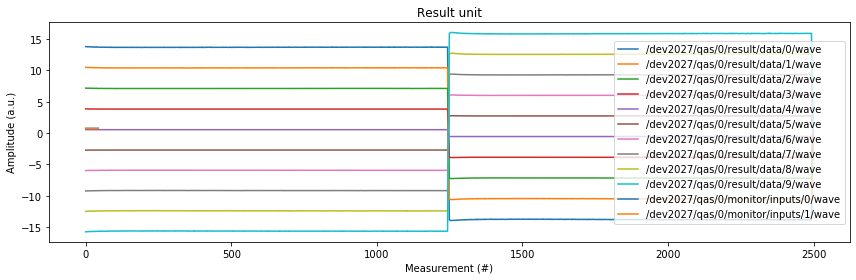

Test 2: Integration Length: 43, amplitude: 0.4165224893890871, weightLength: 55 input. 
Error in channel 0 is 4.33700717411979e-05, and expected value is 13.78917225614, actual value is 13.78857421875
Error in channel 1 is 5.7072122367968967e-05, and expected value is 10.47862538114, actual value is 10.47802734375
Error in channel 2 is 8.343064176646158e-05, and expected value is 7.16807850614, actual value is 7.16748046875
Error in channel 3 is 0.00015503110465055293, and expected value is 3.85753163114, actual value is 3.85693359375
Error in channel 4 is 0.001093334655649719, and expected value is 0.54698475614, actual value is 0.54638671875
Error in channel 5 is 0.016214592771642382, and expected value is -2.76356, actual value is -2.71875
Error in channel 6 is 0.016300553333844642, and expected value is -6.07410899386, actual value is -5.97509765625
Error in channel 7 is 0.0163256445990446, and expected value is -9.3846558689, actual value is -9.2314453125
Error in channel 8 is 0.0

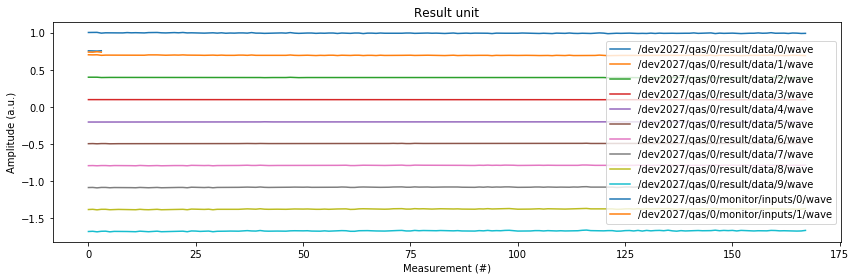

Test 4: Result Length: 168, amplitude: 0.3326538546289429, weightLength: 62 input. 
Error in channel 0 is 0.0013640530128307534, and expected value is 1.003321709, actual value is 1.001953125
Error in channel 1 is 7.157458599522797e-05, and expected value is 0.70171038088, actual value is 0.70166015625
Error in channel 2 is 0.0004916507765841028, and expected value is 0.40009905276, actual value is 0.39990234375
Error in channel 3 is 0.003484631016599366, and expected value is 0.09848772463, actual value is 0.09814453125
Error in channel 4 is 0.0024107378541268773, and expected value is -0.20312360349, actual value is -0.20361328125
Error in channel 5 is 0.01905503958188902, and expected value is -0.5047349316, actual value is -0.4951171875
Error in channel 6 is 0.019012471143600246, and expected value is -0.80634626, actual value is -0.791015625
Error in channel 7 is 0.02031519018997058, and expected value is -1.10795758787, actual value is -1.08544921875
Error in channel 8 is 0.02002

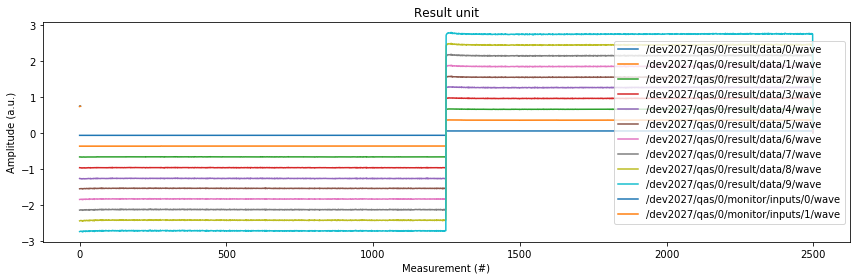

Test 1: Window Type: blackman, amplitude: 0.08048062123383326, weightLength: 732 input. 
Error in channel 0 is 0.0222620159529564, and expected value is -0.0601836286, actual value is -0.0615234375
Error in channel 1 is 0.0037319360343082007, and expected value is -0.3590117536, actual value is -0.3603515625
Error in channel 2 is 0.0020366793555466906, and expected value is -0.6578398786, actual value is -0.6591796875
Error in channel 3 is 0.001400495150834123, and expected value is -0.9566680036, actual value is -0.9580078125
Error in channel 4 is 0.0010671549433562087, and expected value is -1.2554961286, actual value is -1.2568359375
Error in channel 5 is 0.008562324730988828, and expected value is -1.554324254, actual value is -1.541015625
Error in channel 6 is 0.008762536900644663, and expected value is -1.8531523786, actual value is -1.8369140625
Error in channel 7 is 0.0089071439076702, and expected value is -2.1519805, actual value is -2.1328125
Error in channel 8 is 0.00841879

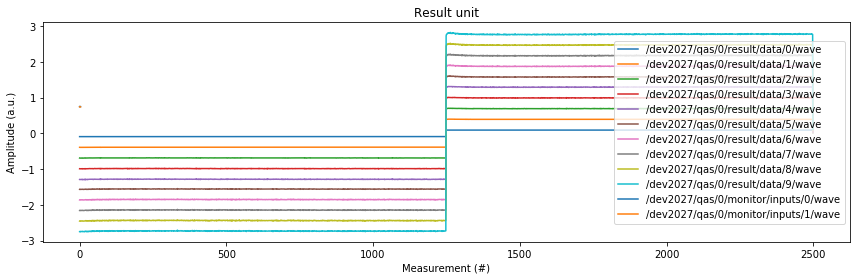

Test 1: Window Type: blackman, amplitude: 0.12134053355401275, weightLength: 488 input. 
Error in channel 0 is 0.016046885787690413, and expected value is -0.09082765524, actual value is -0.09228515625
Error in channel 1 is 0.0003558844841636892, and expected value is -0.39097413962, actual value is -0.39111328125
Error in channel 2 is 0.00041328531045714816, and expected value is -0.69112062, actual value is -0.69140625
Error in channel 3 is 0.0004359171976467191, and expected value is -0.99126710837, actual value is -0.99169921875
Error in channel 4 is 0.0004480321434362657, and expected value is -1.2914135927, actual value is -1.2919921875
Error in channel 5 is 0.014270539451516765, and expected value is -1.59156007712, actual value is -1.56884765625
Error in channel 6 is 0.014251929072321113, and expected value is -1.89170656149, actual value is -1.86474609375
Error in channel 7 is 0.014238415608566691, and expected value is -2.19185304587, actual value is -2.16064453125
Error in c

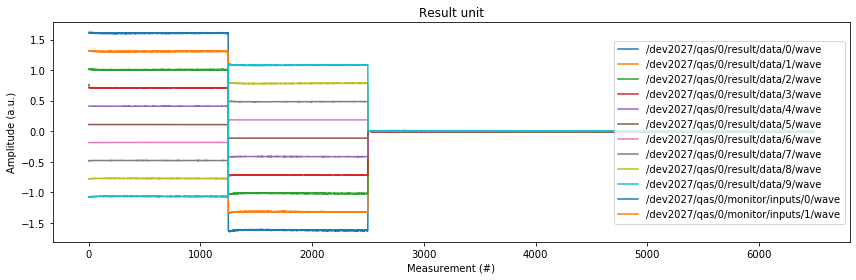

Test 4: Result Length: 6488, amplitude: 0.5374125643418382, weightLength: 678 input. 
Error in channel 0 is 0.0004552153527280483, and expected value is 1.6149929821, actual value is 1.6142578125
Error in channel 1 is 0.00039212683156960264, and expected value is 1.31448028674, actual value is 1.31396484375
Error in channel 2 is 0.00029164245743618685, and expected value is 1.013967591, actual value is 1.013671875
Error in channel 3 is 0.00010650969026120203, and expected value is 0.71345489611, actual value is 0.71337890625
Error in channel 4 is 0.003199254150921337, and expected value is 0.4129422008, actual value is 0.41162109375
Error in channel 5 is 0.02282518480194018, and expected value is 0.11242950549, actual value is 0.10986328125
Error in channel 6 is 0.010888977223110753, and expected value is -0.18808318982, actual value is -0.18603515625
Error in channel 7 is 0.013635586366207396, and expected value is -0.48859588514, actual value is -0.48193359375
Error in channel 8 is 0

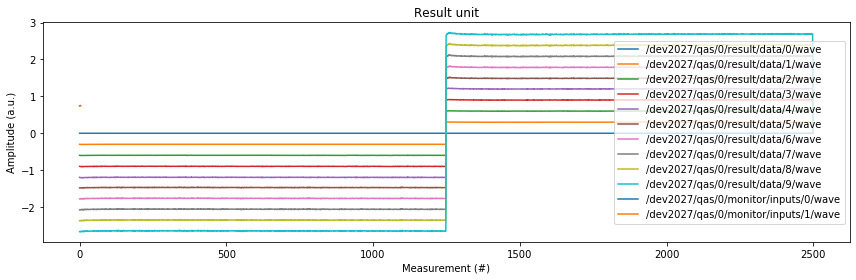

Test 1: Window Type: hann, amplitude: 0.8887837290699301, weightLength: 982 input. 
Error in channel 0 is 0, and expected value is 0.0, actual value is 0.0
Error in channel 1 is 0.0004904352323415897, and expected value is -0.298681641, actual value is -0.298828125
Error in channel 2 is 0.0004904385820299298, and expected value is -0.59736328, actual value is -0.59765625
Error in channel 3 is 0.0004904363489044292, and expected value is -0.896044922, actual value is -0.896484375
Error in channel 4 is 0.0004904050851466076, and expected value is -1.1947266, actual value is -1.1953125
Error in channel 5 is 0.00833742030075049, and expected value is -1.49340820312, actual value is -1.48095703125
Error in channel 6 is 0.007683505013790267, and expected value is -1.7920898438, actual value is -1.7783203125
Error in channel 7 is 0.007917044095129853, and expected value is -2.09077148, actual value is -2.07421875
Error in channel 8 is 0.008092202059833326, and expected value is -2.389453125, 

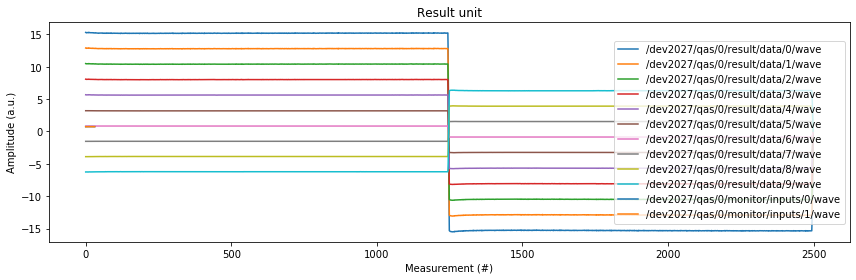

Test 2: Integration Length: 31, amplitude: 0.6357216124884763, weightLength: 398 input. 
Error in channel 0 is 5.187043499133092e-05, and expected value is 15.30108664277, actual value is 15.30029296875
Error in channel 1 is 5.019229620949508e-05, and expected value is 12.8942018771, actual value is 12.8935546875
Error in channel 2 is 4.774388575028859e-05, and expected value is 10.48731711152, actual value is 10.48681640625
Error in channel 3 is 4.383688704176986e-05, and expected value is 8.080432346, actual value is 8.080078125
Error in channel 4 is 3.661492515240031e-05, and expected value is 5.67354758027, actual value is 5.67333984375
Error in channel 5 is 0.0179556340611121, and expected value is 3.2666628146, actual value is 3.2080078125
Error in channel 6 is 0.018644304356928505, and expected value is 0.85978, actual value is 0.84375
Error in channel 7 is 0.01719267573115783, and expected value is -1.5471067166, actual value is -1.5205078125
Error in channel 8 is 0.01713736961

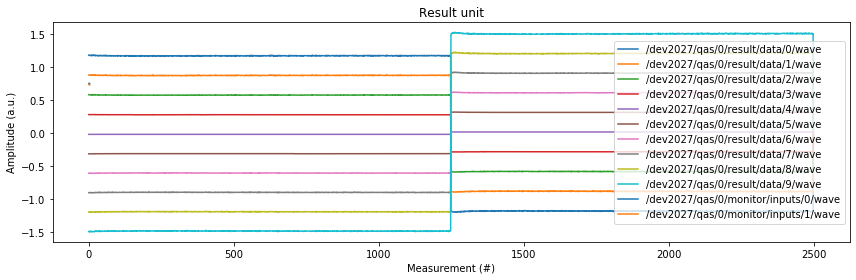

Test 1: Window Type: boxcar, amplitude: 0.39386190545273836, weightLength: 736 input. 
Error in channel 0 is 0.0012266513662377956, and expected value is 1.18504739, actual value is 1.18359375
Error in channel 1 is 0.0009813805544396591, and expected value is 0.88416848701, actual value is 0.88330078125
Error in channel 2 is 0.000483067603596804, and expected value is 0.5832895808, actual value is 0.5830078125
Error in channel 3 is 0.004107503275379747, and expected value is 0.28241, actual value is 0.28125
Error in channel 4 is 0.03112030529458797, and expected value is -0.01846823174, actual value is -0.01904296875
Error in channel 5 is 0.013796058319889922, and expected value is -0.31934713799, actual value is -0.31494140625
Error in channel 6 is 0.01749523560766568, and expected value is -0.620226, actual value is -0.609375
Error in channel 7 is 0.017187523518797942, and expected value is -0.9211049505, actual value is -0.9052734375
Error in channel 8 is 0.018230048921783676, and e

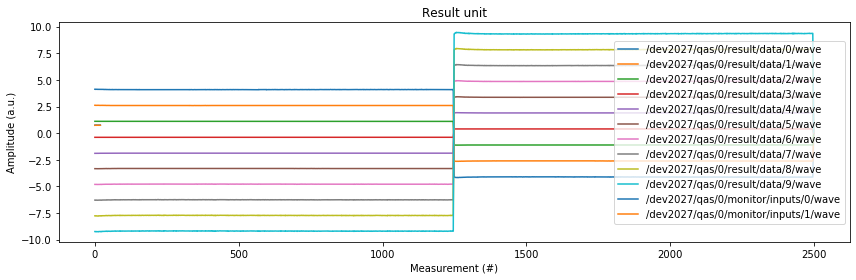

Test 2: Integration Length: 20, amplitude: 0.2738700953063985, weightLength: 255 input. 
Error in channel 0 is 0.00016616118147475554, and expected value is 4.12129026721, actual value is 4.12060546875
Error in channel 1 is 9.377007428446045e-05, and expected value is 2.6164562828, actual value is 2.6162109375
Error in channel 2 is 0.001143136478743404, and expected value is 1.1116222985, actual value is 1.1103515625
Error in channel 3 is 0.002114084778727228, and expected value is -0.39321168591, actual value is -0.39404296875
Error in channel 4 is 0.0002064228485120528, and expected value is -1.8980457, actual value is -1.8984375
Error in channel 5 is 0.018954754489090092, and expected value is -3.40287965466, actual value is -3.33837890625
Error in channel 6 is 0.018903350849978896, and expected value is -4.90771363904, actual value is -4.81494140625
Error in channel 7 is 0.018876073016301852, and expected value is -6.41254762341, actual value is -6.29150390625
Error in channel 8 is

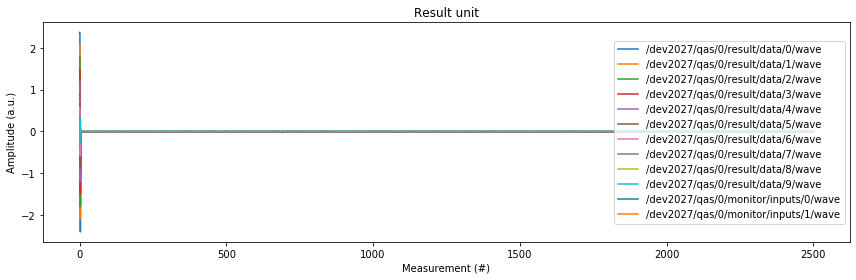

Test 0: User Delay: 542, amplitude: 0.794807599278776, weightLength: 905 input. 
Error in channel 0 is 0.0005222344550200024, and expected value is 2.36695876367, actual value is 2.36572265625
Error in channel 1 is 0.00038501398098295575, and expected value is 2.069156029, actual value is 2.068359375
Error in channel 2 is 0.00020165439103782208, and expected value is 1.77135329492, actual value is 1.77099609375
Error in channel 3 is 0.0009382723857700955, and expected value is 1.47355056055, actual value is 1.47216796875
Error in channel 4 is 0.00080216070060557, and expected value is 1.1757478262, actual value is 1.1748046875
Error in channel 5 is 0.012253157970811652, and expected value is 0.8779451, actual value is 0.8671875
Error in channel 6 is 0.012735583043544314, and expected value is 0.58014235742, actual value is 0.57275390625
Error in channel 7 is 0.014235729499433327, and expected value is 0.282339623, actual value is 0.2783203125
Error in channel 8 is 0.04204651354599027, 

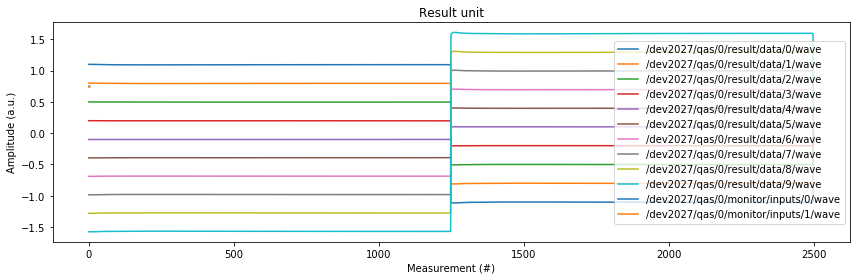

Test 3: Averages: 256, amplitude: 0.36641254600255013, weightLength: 327 input. 
Error in channel 0 is 0.0006803468575108657, and expected value is 1.0993864986954758, actual value is 1.0986385345458984
Error in channel 1 is 0.0010294954656066024, and expected value is 0.7993458721696, actual value is 0.79852294921875
Error in channel 2 is 0.00147738176875947, and expected value is 0.4993052456437178, actual value is 0.4985675811767578
Error in channel 3 is 0.003475079055317853, and expected value is 0.19926461911783885, actual value is 0.19857215881347656
Error in channel 4 is 0.0042083067451607024, and expected value is -0.10077600740804, actual value is -0.10120010375976562
Error in channel 5 is 0.014743989527712682, and expected value is -0.4008166339339188, actual value is -0.39490699768066406
Error in channel 6 is 0.015460702454749616, and expected value is -0.700857260459798, actual value is -0.6900215148925781
Error in channel 7 is 0.015976391722916063, and expected value is -1

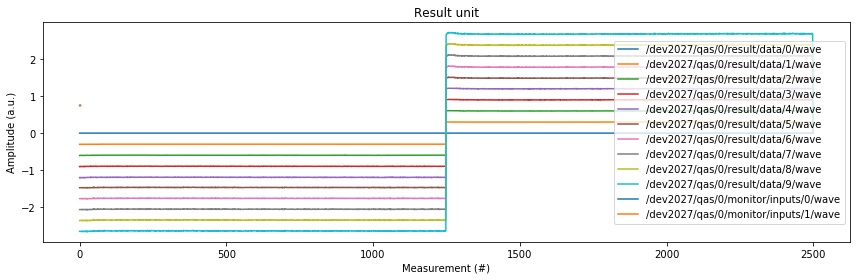

Test 1: Window Type: gaussian, amplitude: 0.8569816875817575, weightLength: 633 input. 
Error in channel 0 is 0, and expected value is 0.0, actual value is 0.0
Error in channel 1 is 0.0014584345304250546, and expected value is -0.3013183594, actual value is -0.3017578125
Error in channel 2 is 0.0014584341980661106, and expected value is -0.602636719, actual value is -0.603515625
Error in channel 3 is 0.0014584346412114307, and expected value is -0.9039550781, actual value is -0.9052734375
Error in channel 4 is 0.00024307243558576772, and expected value is -1.2052734375, actual value is -1.20556640625
Error in channel 5 is 0.018959649978948584, and expected value is -1.50659179688, actual value is -1.47802734375
Error in channel 6 is 0.019607843110140914, and expected value is -1.8079101562, actual value is -1.7724609375
Error in channel 7 is 0.01937634575389931, and expected value is -2.109228516, actual value is -2.068359375
Error in channel 8 is 0.019202722411278596, and expected val

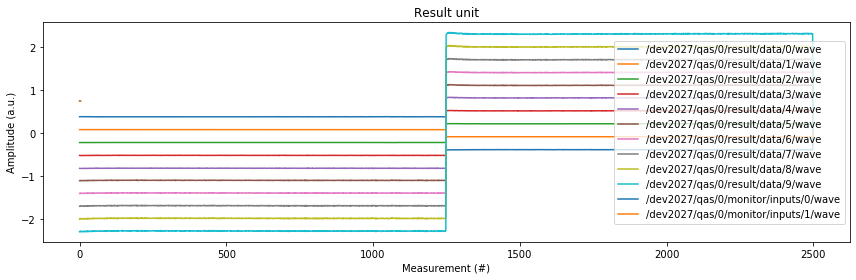

Test 3: Averages: 1, amplitude: 0.12746254206761487, weightLength: 290 input. 
Error in channel 0 is 0.0027792905694353294, and expected value is 0.381920844, actual value is 0.380859375
Error in channel 1 is 0.0031087512422973335, and expected value is 0.08228706, actual value is 0.08203125
Error in channel 2 is 0.004209794389204157, and expected value is -0.21734673369, actual value is -0.21826171875
Error in channel 3 is 0.00021146057769939666, and expected value is -0.51698052275, actual value is -0.51708984375
Error in channel 4 is 0.0009410815961650988, and expected value is -0.8166143118, actual value is -0.8173828125
Error in channel 5 is 0.011843923514474412, and expected value is -1.11624810088, actual value is -1.10302734375
Error in channel 6 is 0.01197565193147475, and expected value is -1.41588188994, actual value is -1.39892578125
Error in channel 7 is 0.011207485151757629, and expected value is -1.715515679, actual value is -1.6962890625
Error in channel 8 is 0.01139468

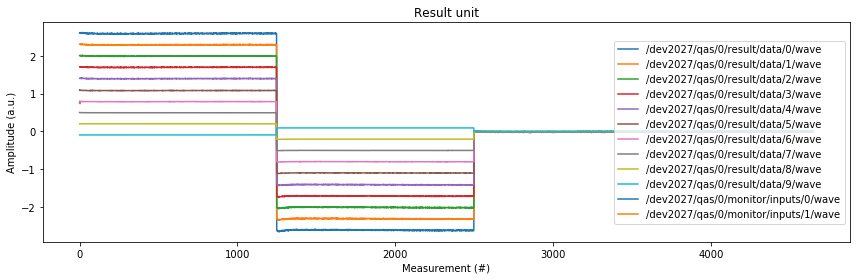

Test 4: Result Length: 4648, amplitude: 0.8687033421554158, weightLength: 876 input. 
Error in channel 0 is 7.633016539449738e-06, and expected value is 2.61183634244, actual value is 2.61181640625
Error in channel 1 is 0.0004839823696894818, and expected value is 2.31117716275, actual value is 2.31005859375
Error in channel 2 is 0.00037421102738784855, and expected value is 2.010517983, actual value is 2.009765625
Error in channel 3 is 0.00022583568259357674, and expected value is 1.70985880338, actual value is 1.70947265625
Error in channel 4 is 0.0010536335058847453, and expected value is 1.40919962369, actual value is 1.40771484375
Error in channel 5 is 0.015544629285532824, and expected value is 1.108540444, actual value is 1.09130859375
Error in channel 6 is 0.015436808131077269, and expected value is 0.80788126432, actual value is 0.79541015625
Error in channel 7 is 0.01520116358029716, and expected value is 0.50722208463, actual value is 0.49951171875
Error in channel 8 is 0.02

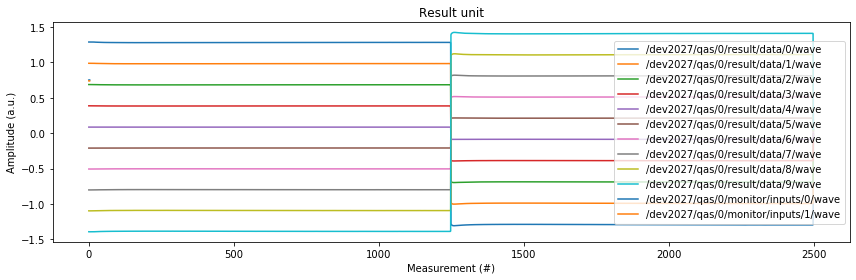

Test 3: Averages: 512, amplitude: 0.4287326212138697, weightLength: 976 input. 
Error in channel 0 is 0.0005816978378362124, and expected value is 1.2864119077616398, actual value is 1.2856636047363281
Error in channel 1 is 0.0007004928486200347, and expected value is 0.986361982911176, actual value is 0.9856710433959961
Error in channel 2 is 0.0010398835912088524, and expected value is 0.686312058060712, actual value is 0.6855983734130859
Error in channel 3 is 0.0019732169453963466, and expected value is 0.3862621332102482, actual value is 0.3854999542236328
Error in channel 4 is 0.01152712374803563, and expected value is 0.08621220835978435, actual value is 0.08521842956542969
Error in channel 5 is 0.013509180916681228, and expected value is -0.21383771649067945, actual value is -0.21094894409179688
Error in channel 6 is 0.015314546938862094, and expected value is -0.5138876413411435, actual value is -0.5060176849365234
Error in channel 7 is 0.015939999498830827, and expected value i

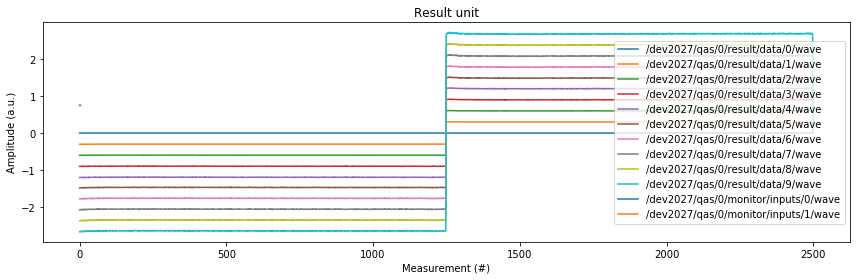

Test 1: Window Type: triang, amplitude: 0.9890451477414319, weightLength: 658 input. 
Error in channel 0 is 0, and expected value is 0.0, actual value is 0.0
Error in channel 1 is 0.003654080348041337, and expected value is -0.3006591797, actual value is -0.3017578125
Error in channel 2 is 0.0012180267882643335, and expected value is -0.60131835938, actual value is -0.60205078125
Error in channel 3 is 0.00040600789239168133, and expected value is -0.90197754, actual value is -0.90234375
Error in channel 4 is 0.0, and expected value is -1.20263671875, actual value is -1.20263671875
Error in channel 5 is 0.013885505194134418, and expected value is -1.503295898, actual value is -1.482421875
Error in channel 6 is 0.013398294765219327, and expected value is -1.80395507813, actual value is -1.77978515625
Error in channel 7 is 0.013746302417481777, and expected value is -2.10461425781, actual value is -2.07568359375
Error in channel 8 is 0.013398294967576174, and expected value is -2.40527343

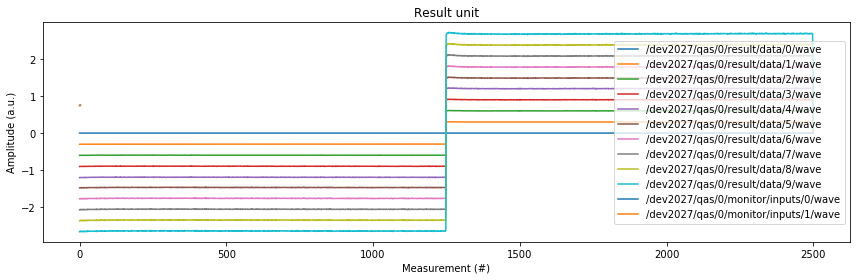

Test 1: Window Type: gaussian, amplitude: 0.035651521449599266, weightLength: 5 input. 
Error in channel 0 is 0, and expected value is 0.0, actual value is 0.0
Error in channel 1 is 0.004143309815104436, and expected value is -0.3005126953, actual value is -0.3017578125
Error in channel 2 is 0.0017060687218640328, and expected value is -0.60102539063, actual value is -0.60205078125
Error in channel 3 is 0.0008936505389362322, and expected value is -0.90153809, actual value is -0.90234375
Error in channel 4 is 0.00048744820862775935, and expected value is -1.20205078125, actual value is -1.20263671875
Error in channel 5 is 0.014379722152881184, and expected value is -1.50256347656, actual value is -1.48095703125
Error in channel 6 is 0.014542204893463024, and expected value is -1.80307617188, actual value is -1.77685546875
Error in channel 7 is 0.01396191072260229, and expected value is -2.10358887, actual value is -2.07421875
Error in channel 8 is 0.014135998050207238, and expected val

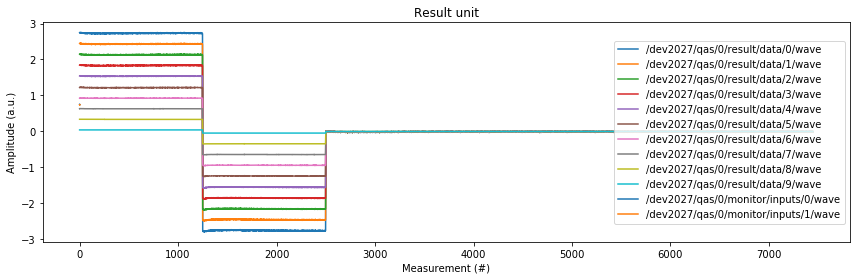

Test 4: Result Length: 7448, amplitude: 0.9148185354174729, weightLength: 805 input. 
Error in channel 0 is 0.00020155808910483455, and expected value is 2.74713573868, actual value is 2.74658203125
Error in channel 1 is 0.0002262946384669277, and expected value is 2.4468427699, actual value is 2.4462890625
Error in channel 2 is 0.0002579522868258427, and expected value is 2.14654980118, actual value is 2.14599609375
Error in channel 3 is 0.00029990789493793645, and expected value is 1.846256832, actual value is 1.845703125
Error in channel 4 is 0.00035816324236835536, and expected value is 1.54596386368, actual value is 1.54541015625
Error in channel 5 is 0.018083720003160064, and expected value is 1.24567089493, actual value is 1.22314453125
Error in channel 6 is 0.01917945398118778, and expected value is 0.94537792618, actual value is 0.92724609375
Error in channel 7 is 0.019024624661866295, and expected value is 0.645085, actual value is 0.6328125
Error in channel 8 is 0.0185998591

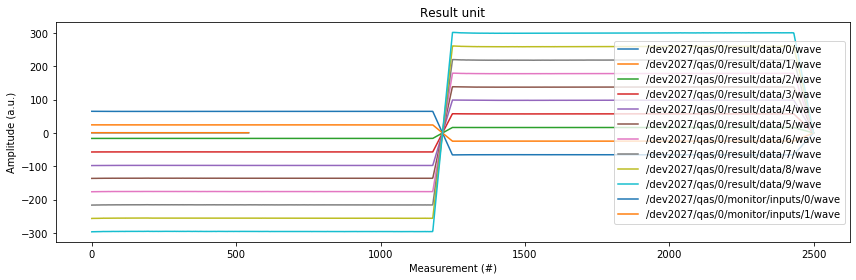

Test 2: Integration Length: 544, amplitude: 0.15981879608452054, weightLength: 870 input. 
Error in channel 0 is 9.706271565128376e-05, and expected value is 65.12155525, actual value is 65.115234375
Error in channel 1 is 9.706056334684572e-05, and expected value is 24.374436109, actual value is 24.3720703125
Error in channel 2 is 9.706900189107401e-05, and expected value is -16.37268303, actual value is -16.37109375
Error in channel 3 is 9.706545697202831e-05, and expected value is -57.1198021722, actual value is -57.1142578125
Error in channel 4 is 2.222629516513e-05, and expected value is -97.86692131283, actual value is -97.86474609375
Error in channel 5 is 0.015864203826723322, and expected value is -138.6140404535, actual value is -136.4150390625
Error in channel 6 is 0.015883887957000173, and expected value is -179.36115959408, actual value is -176.51220703125
Error in channel 7 is 0.01586966369495561, and expected value is -220.108278735, actual value is -216.615234375
Error in

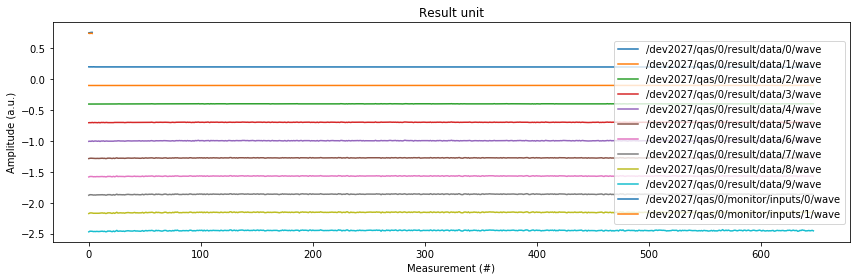

Test 4: Result Length: 648, amplitude: 0.0663169740540479, weightLength: 869 input. 
Error in channel 0 is 0.0030350022884999095, and expected value is 0.19982522, actual value is 0.19921875
Error in channel 1 is 0.010305339726740099, and expected value is -0.1014931412, actual value is -0.1025390625
Error in channel 2 is 5.096852987687496e-05, and expected value is -0.40281150054, actual value is -0.40283203125
Error in channel 3 is 0.000653265620708475, and expected value is -0.70412985992, actual value is -0.70458984375
Error in channel 4 is 0.0008945631836068932, and expected value is -1.00544821929, actual value is -1.00634765625
Error in channel 5 is 0.016910908406068605, and expected value is -1.30676657867, actual value is -1.28466796875
Error in channel 6 is 0.016201687704382028, and expected value is -1.60808494, actual value is -1.58203125
Error in channel 7 is 0.016483479390057076, and expected value is -1.9094032974, actual value is -1.8779296875
Error in channel 8 is 0.01

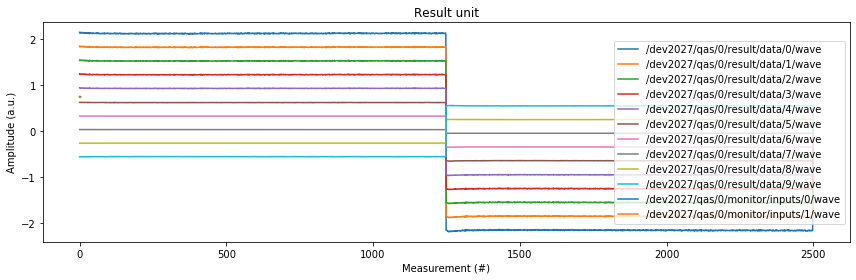

Test 2: Integration Length: 1, amplitude: 0.7134880569750904, weightLength: 21 input. 
Error in channel 0 is 4.894880509521178e-05, and expected value is 2.15196080466, actual value is 2.15185546875
Error in channel 1 is 0.00013609336138607167, and expected value is 1.85034947653, actual value is 1.85009765625
Error in channel 2 is 0.00025718011815550066, and expected value is 1.54873814841, actual value is 1.54833984375
Error in channel 3 is 0.0004368353090809077, and expected value is 1.24712682028, actual value is 1.24658203125
Error in channel 4 is 0.0007311074389915903, and expected value is 0.94551549216, actual value is 0.94482421875
Error in channel 5 is 0.019500584840782195, and expected value is 0.64390416403, actual value is 0.63134765625
Error in channel 6 is 0.019993457186464145, and expected value is 0.34229283591, actual value is 0.33544921875
Error in channel 7 is 0.027794607223380566, and expected value is 0.04068150778, actual value is 0.03955078125
Error in channel 8

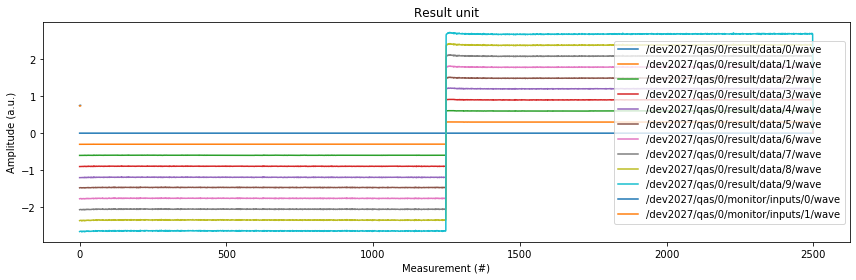

Test 1: Window Type: hann, amplitude: 0.10465756290960315, weightLength: 228 input. 
Error in channel 0 is 0, and expected value is 0.0, actual value is 0.0
Error in channel 1 is 0.002433090107582447, and expected value is -0.3010253906, actual value is -0.3017578125
Error in channel 2 is 0.0, and expected value is -0.60205078125, actual value is -0.60205078125
Error in channel 3 is 0.0008110300025691777, and expected value is -0.90307617188, actual value is -0.90380859375
Error in channel 4 is 0.0, and expected value is -1.2041015625, actual value is -1.2041015625
Error in channel 5 is 0.0170316301539893, and expected value is -1.5051269531, actual value is -1.4794921875
Error in channel 6 is 0.017031630306374654, and expected value is -1.806152344, actual value is -1.775390625
Error in channel 7 is 0.017031630181978445, and expected value is -2.1071777344, actual value is -2.0712890625
Error in channel 8 is 0.01703161996594064, and expected value is -2.4082031, actual value is -2.367

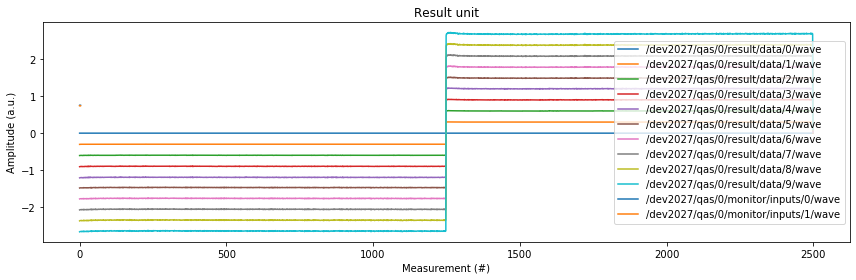

Test 1: Window Type: gaussian, amplitude: 0.42588894443079595, weightLength: 990 input. 
Error in channel 0 is 0, and expected value is 0.0, actual value is 0.0
Error in channel 1 is 0.004123211262254128, and expected value is -0.30197753906, actual value is -0.30322265625
Error in channel 2 is 0.0016977928609770577, and expected value is -0.60395507813, actual value is -0.60498046875
Error in channel 3 is 0.0008893200716175047, and expected value is -0.90593261719, actual value is -0.90673828125
Error in channel 4 is 0.0004850836769341976, and expected value is -1.20791015625, actual value is -1.20849609375
Error in channel 5 is 0.018190637681831014, and expected value is -1.509887695, actual value is -1.482421875
Error in channel 6 is 0.018514027016533784, and expected value is -1.8118652344, actual value is -1.7783203125
Error in channel 7 is 0.018052042549929585, and expected value is -2.11384277344, actual value is -2.07568359375
Error in channel 8 is 0.01831190880426881, and expe

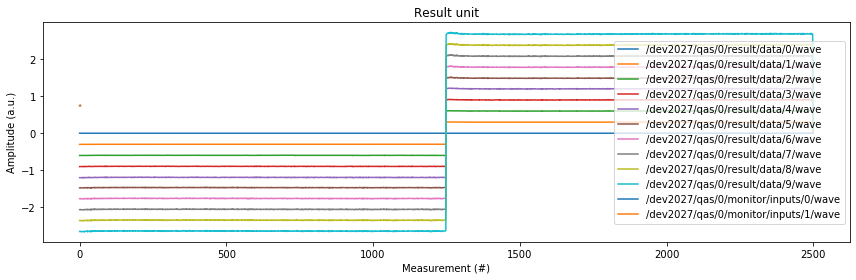

Test 1: Window Type: hann, amplitude: 0.6935803040443064, weightLength: 652 input. 
Error in channel 0 is 0, and expected value is 0.0, actual value is 0.0
Error in channel 1 is 0.00463301646290473, and expected value is -0.3003662109, actual value is -0.3017578125
Error in channel 2 is 0.002194586677832701, and expected value is -0.60073242188, actual value is -0.60205078125
Error in channel 3 is 0.0013817799279086558, and expected value is -0.90109863, actual value is -0.90234375
Error in channel 4 is 0.000975371860521861, and expected value is -1.20146484375, actual value is -1.20263671875
Error in channel 5 is 0.016825194257862934, and expected value is -1.5018311, actual value is -1.4765625
Error in channel 6 is 0.01731285052153604, and expected value is -1.80219726562, actual value is -1.77099609375
Error in channel 7 is 0.01696450343004995, and expected value is -2.10256347656, actual value is -2.06689453125
Error in channel 8 is 0.01731285072873924, and expected value is -2.402

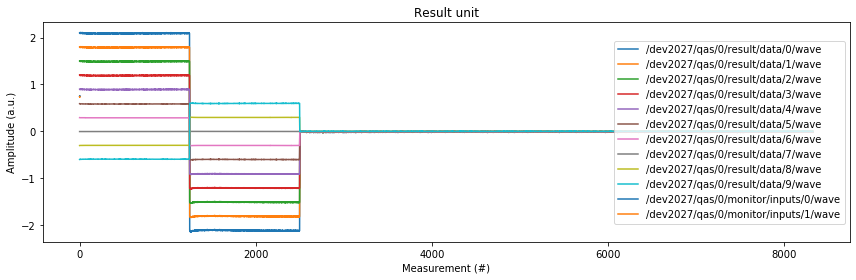

Test 4: Result Length: 8328, amplitude: 0.6995039239575984, weightLength: 674 input. 
Error in channel 0 is 0.000475748464454715, and expected value is 2.1015857637, actual value is 2.1005859375
Error in channel 1 is 0.00047377708572481905, and expected value is 1.8011463106, actual value is 1.80029296875
Error in channel 2 is 0.0, and expected value is 1.5, actual value is 1.5
Error in channel 3 is 0.0004668735466521879, and expected value is 1.20026740435, actual value is 1.19970703125
Error in channel 4 is 0.00045996426255494083, and expected value is 0.8998279512, actual value is 0.8994140625
Error in channel 5 is 0.015109510574040069, and expected value is 0.5993884981, actual value is 0.59033203125
Error in channel 6 is 0.01510441764516127, and expected value is 0.29894904498, actual value is 0.29443359375
Error in channel 7 is 0.01715261688551554, and expected value is -0.00149040815, actual value is -0.00146484375
Error in channel 8 is 0.010273034901970233, and expected value i

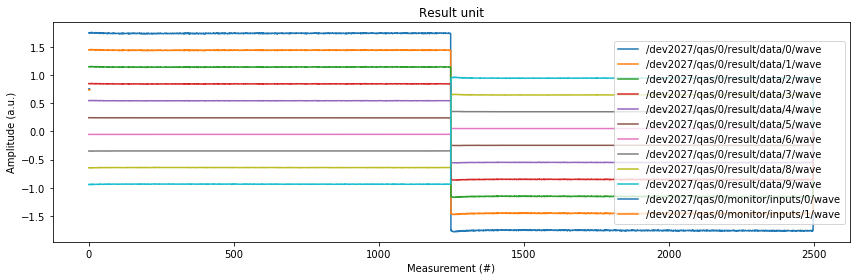

Test 1: Window Type: boxcar, amplitude: 0.5824935089638479, weightLength: 605 input. 
Error in channel 0 is 0.0005495823569038416, and expected value is 1.7470539, actual value is 1.74609375
Error in channel 1 is 0.0009165447907711358, and expected value is 1.44712713809, actual value is 1.44580078125
Error in channel 2 is 0.00019850414444976956, and expected value is 1.14720038028, actual value is 1.14697265625
Error in channel 3 is 0.0007009955039642998, and expected value is 0.8472736225, actual value is 0.8466796875
Error in channel 4 is 0.0017541817849162356, and expected value is 0.54734686465, actual value is 0.54638671875
Error in channel 5 is 0.01720169130571247, and expected value is 0.2474201068, actual value is 0.2431640625
Error in channel 6 is 0.004337050557652183, and expected value is -0.052506651, actual value is -0.052734375
Error in channel 7 is 0.014940240904592747, and expected value is -0.35243340878, actual value is -0.34716796875
Error in channel 8 is 0.01424636

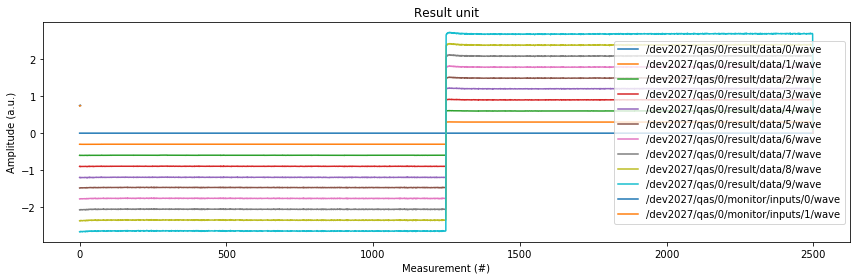

Test 1: Window Type: triang, amplitude: 0.9414527634162988, weightLength: 193 input. 
Error in channel 0 is 0, and expected value is 0.0, actual value is 0.0
Error in channel 1 is 0.00367197061584855, and expected value is -0.29919433594, actual value is -0.30029296875
Error in channel 2 is 0.0012239901997123342, and expected value is -0.59838867188, actual value is -0.59912109375
Error in channel 3 is 0.0004079967388125061, and expected value is -0.89758300781, actual value is -0.89794921875
Error in channel 4 is 0.0, and expected value is -1.19677734375, actual value is -1.19677734375
Error in channel 5 is 0.009057527746781962, and expected value is -1.49597168, actual value is -1.482421875
Error in channel 6 is 0.009383924914804965, and expected value is -1.7951660156, actual value is -1.7783203125
Error in channel 7 is 0.009617065181739184, and expected value is -2.09436035, actual value is -2.07421875
Error in channel 8 is 0.009791921664626682, and expected value is -2.3935546875,

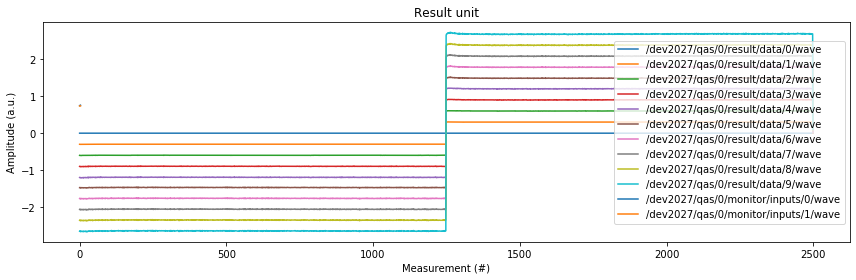

Test 1: Window Type: hann, amplitude: 0.8007390013311921, weightLength: 748 input. 
Error in channel 0 is 0, and expected value is 0.0, actual value is 0.0
Error in channel 1 is 0.0019550342130988034, and expected value is -0.29970703125, actual value is -0.30029296875
Error in channel 2 is 0.0019550342130988034, and expected value is -0.5994140625, actual value is -0.6005859375
Error in channel 3 is 0.00032583897988841895, and expected value is -0.8991210938, actual value is -0.8994140625
Error in channel 4 is 0.0007331378299120976, and expected value is -1.198828125, actual value is -1.19970703125
Error in channel 5 is 0.016617790778527746, and expected value is -1.4985351562, actual value is -1.4736328125
Error in channel 6 is 0.016780710329097476, and expected value is -1.7982421875, actual value is -1.76806640625
Error in channel 7 is 0.01619885490853241, and expected value is -2.09794921875, actual value is -2.06396484375
Error in channel 8 is 0.016373411534701784, and expected v

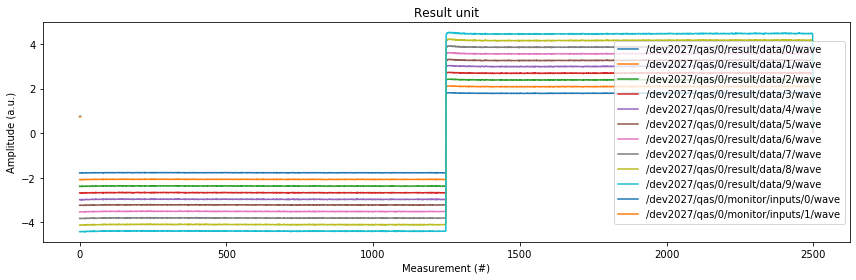

Test 1: Window Type: flattop, amplitude: 0.5947007165829314, weightLength: 919 input. 
Error in channel 0 is 0.0005320014046159585, and expected value is -1.7832310061, actual value is -1.7841796875
Error in channel 1 is 0.0006663841459653298, and expected value is -2.08308452175, actual value is -2.08447265625
Error in channel 2 is 0.0001522254772516649, and expected value is -2.38293803737, actual value is -2.38330078125
Error in channel 3 is 0.00029901689529321206, and expected value is -2.68279155, actual value is -2.68359375
Error in channel 4 is 0.0004162916141324067, and expected value is -2.98264506862, actual value is -2.98388671875
Error in channel 5 is 0.014214397752942413, and expected value is -3.28249858425, actual value is -3.23583984375
Error in channel 6 is 0.01453756106259175, and expected value is -3.5823520999, actual value is -3.5302734375
Error in channel 7 is 0.01443348074700061, and expected value is -3.882205615, actual value is -3.826171875
Error in channel 8 

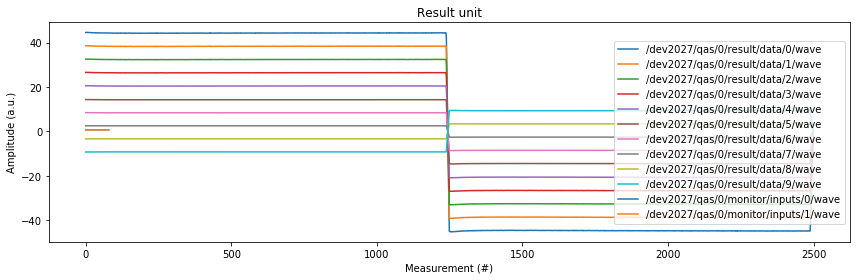

Test 2: Integration Length: 80, amplitude: 0.7430862638589887, weightLength: 93 input. 
Error in channel 0 is 2.5932680077255353e-05, and expected value is 44.608578695, actual value is 44.607421875
Error in channel 1 is 2.427361429364687e-05, and expected value is 38.6054292808, actual value is 38.6044921875
Error in channel 2 is 2.2004596065050103e-05, and expected value is 32.6022799, actual value is 32.6015625
Error in channel 3 is 1.870888602496057e-05, and expected value is 26.5991304526, actual value is 26.5986328125
Error in channel 4 is 8.461637863888268e-05, and expected value is 20.59598103858, actual value is 20.59423828125
Error in channel 5 is 0.015563050003838494, and expected value is 14.59283162452, actual value is 14.36572265625
Error in channel 6 is 0.015499903074181995, and expected value is 8.58968221045, actual value is 8.45654296875
Error in channel 7 is 0.015709972421983468, and expected value is 2.5865327964, actual value is 2.5458984375
Error in channel 8 is 0

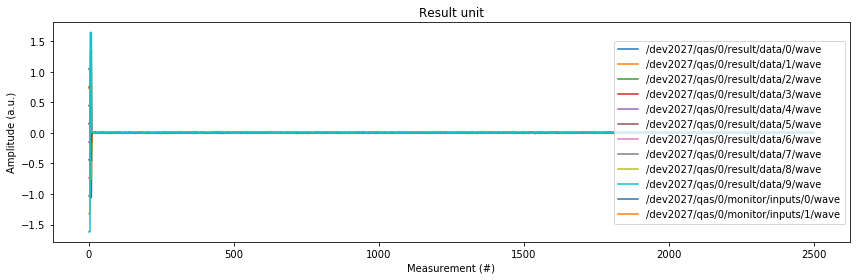

Test 0: User Delay: 244, amplitude: 0.35018904985420174, weightLength: 680 input. 
Error in channel 0 is 0.00046975755777708923, and expected value is 1.04492445491, actual value is 1.04443359375
Error in channel 1 is 0.0012461750811349449, and expected value is 0.74653578304, actual value is 0.74560546875
Error in channel 2 is 0.0030565128634979823, and expected value is 0.44814711116, actual value is 0.44677734375
Error in channel 3 is 0.002299548537028526, and expected value is 0.1497584393, actual value is 0.1494140625
Error in channel 4 is 0.005273690865501645, and expected value is -0.1486302326, actual value is -0.1494140625
Error in channel 5 is 0.013648048548125551, and expected value is -0.44701890446, actual value is -0.44091796875
Error in channel 6 is 0.0134906246189706, and expected value is -0.7454075763, actual value is -0.7353515625
Error in channel 7 is 0.01342320590251938, and expected value is -1.04379624821, actual value is -1.02978515625
Error in channel 8 is 0.01

KeyboardInterrupt: 

In [238]:
###### RUN OVERNIGHT 03/03/2020 ######

N = 10000
device_id = 'dev2027'
# Window types 
winType = ['boxcar', 'triang', 'hann', 'blackman', 'flattop', 'gaussian']

# Initialize DAQ, device ID and tests name (indexed)
daq, device = initializeDAQ(device_id)
testNames = ['User Delay', 'Window Type', 'Integration Length', 'Averages', 'Result Length']
# Tolerance factor
tol = 0.5

# Create expected wave input into QA input monitor
t1 = np.ones(10000, dtype=int)
t2 = np.ones(10000, dtype=int)*-1
simWave = np.concatenate([t1, t2])
simWave = simWave * 0.744

for i in range(N):
    print('############################')
    print(f'Run number {i} executing...')
    print('############################')
    test = np.random.randint(0, 5)
    #test = 2
    # Reset calculation parameters
    userDelay = 1
    integrationLength = 4
    if test == 0:
        ## Window length, Window Amplitude, User delay
        
        # Generate random user delay between 0 to 1024
        parameter = np.random.randint(0, 1025)
        #parameter = 2000

        # Generate the weight function with random window type, length and amplitude
        amplitude = np.random.rand()
        wLen = np.random.randint(0, 1024)
        weights = generateWeights(winType[0], wLen, amplitude)
        
        # Run function
        data = QA_testUserDelay(daq, device, weights, parameter)
        
        # Expected first value
        userDelay = parameter
    elif test == 1:
        ## Window length, Window Amplitude, Window Type
        
        # Generate the weight function with random length and amplitude
        amplitude = np.random.rand() #0.3998632856793166
        wLen = np.random.randint(0, 1024)#997
        parameter = winType[np.random.randint(0, len(winType))]#'boxcar'
        weights = generateWeights(parameter, wLen, amplitude)
        
        # Run function
        data = QA_testWeightFunc(daq, device, weights)
    elif test == 2:
        ## Window length, Window Amplitude, Integration Length
        
        # Generate the weight function with random length and amplitude
        amplitude = np.random.rand()
        wLen = np.random.randint(0, 1024)
        weights = generateWeights(winType[0], wLen, amplitude)

        parameter = np.random.randint(1, len(weights))
        
        # Run function
        data = QA_testIntegrationLength(daq, device, weights, parameter)
        
        # Expected first value
        integrationLength = parameter
    elif test == 3:
        ## Window length, Window Amplitude, Average
        
        # Generate the weight function with random length and amplitude
        amplitude = np.random.rand()
        wLen = np.random.randint(0, 1024)
        weights = generateWeights(winType[0], wLen, amplitude)
        
        averageValues = np.power(2, range(10))
        parameter = averageValues[np.random.randint(0, len(averageValues))]
        
        # Run function
        data = QA_testAverage(daq, device, weights, parameter)
    elif test == 4:
        ## Window length, Window Amplitude, Result Length
        
        # Generate the weight function with random length and amplitude
        amplitude = np.random.rand()
        wLen = np.random.randint(0, 1024)
        weights = generateWeights(winType[0], wLen, amplitude)
        
        # Valid result lengths
        resultValues = np.arange(8, 10008, 80)
        parameter = resultValues[np.random.randint(0, len(resultValues))]
        
        # Run function
        data = QA_testResultLength(daq, device, weights, parameter)
        
        
    print(f'Test {test}: {testNames[test]}: {parameter}, amplitude: {amplitude}, weightLength: {wLen} input. ')
    monitorWave = data[f'/{device_id}/qas/0/monitor/inputs/0/wave']
    for path in range(10):
        samples = data[f'/{device_id}/qas/0/result/data/{path}/wave']
        # Expected first value
        expected = expectedVal(weights, path, monitorWave, userDelay = userDelay, integrationLength = integrationLength)
        expectedRounded = round(expected, str(samples[0])[::-1].find('.'))
        try:
            error = np.abs((samples[0]-expectedRounded)/expectedRounded)
        except RuntimeWarning:
            error = 0
        print(f'Error in channel {path} is {error}, and expected value is {expectedRounded}, actual value is {samples[0]}')
        assert error <= tol, f'ERROR ({path})'

In [186]:
np.sum(data['/dev2027/qas/0/monitor/inputs/0/wave']*(weights[:4]-(0.1*4)))

-0.0004099426969320309

In [199]:
#testWeights = [399.85656738295e-3, 399.85656738295e-3,399.85656738295e-3,399.85656738295e-3]
testWeights = np.full(4, 399.85656738295e-3)
np.sum(data['/dev2027/qas/0/monitor/inputs/0/wave']*(testWeights-(0.1*4)))

-0.0004300877447774314

In [216]:
data

{'/dev2027/qas/0/result/data/0/wave': array([ 2.51074219,  2.49902344,  2.50927734, ..., -0.01757812,
        -0.00585938, -0.01318359]),
 '/dev2027/qas/0/result/data/1/wave': array([ 2.21191406,  2.20166016,  2.21044922, ..., -0.01611328,
        -0.00439453, -0.01171875]),
 '/dev2027/qas/0/result/data/2/wave': array([ 1.91455078,  1.90576172,  1.91308594, ..., -0.01318359,
        -0.00439453, -0.01025391]),
 '/dev2027/qas/0/result/data/3/wave': array([ 1.61572266,  1.60839844,  1.61572266, ..., -0.01171875,
        -0.00439453, -0.00878906]),
 '/dev2027/qas/0/result/data/4/wave': array([ 1.31835938,  1.3125    ,  1.31689453, ..., -0.00878906,
        -0.00292969, -0.00732422]),
 '/dev2027/qas/0/result/data/5/wave': array([ 1.0078125 ,  1.00341797,  1.00488281, ..., -0.01171875,
        -0.00732422, -0.00732422]),
 '/dev2027/qas/0/result/data/6/wave': array([ 0.71337891,  0.71044922,  0.71191406, ..., -0.00732422,
        -0.00585938, -0.00585938]),
 '/dev2027/qas/0/result/data/7/wav

In [204]:
np.floor(2**16 * -1.2128902) / 2**16

-1.212890625

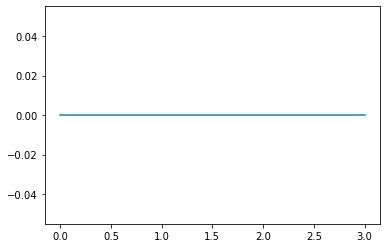

In [91]:
# Create expected wave input into QA input monitor
t1 = np.ones(10000, dtype=int)
t2 = np.ones(10000, dtype=int)*-1
simWave = np.concatenate([t1, t2])
simWave = simWave * 0.744

userDelay = 3000

integrationLength = math.ceil(integrationLength/4)*4
   
sampleDelay = userDelay*8

if((20000-sampleDelay) < integrationLength):
    simWave = np.append(simWave, np.zeros(integrationLength-(20000-sampleDelay)))

simWave = simWave[sampleDelay:sampleDelay+integrationLength]
plt.plot(simWave)

In [165]:
expectedVal(weights, 0, simWave, userDelay = userDelay, integrationLength = integrationLength)

-2.8897643426629855

In [168]:
# Create expected wave input into QA input monitor
t1 = np.ones(10000, dtype=int)
t2 = np.ones(10000, dtype=int)*-1
simWave = np.concatenate([t1, t2])
simWave = simWave * 0.76
expectedVal(weights, 0, simWave, userDelay = userDelay, integrationLength = integrationLength)

-2.9519098123976732

In [127]:
weights

array([0.24455494, 0.24455494, 0.24455494, 0.24455494, 0.24455494,
       0.24455494, 0.24455494, 0.24455494, 0.24455494, 0.24455494,
       0.24455494, 0.24455494, 0.24455494, 0.24455494, 0.24455494,
       0.24455494, 0.24455494, 0.24455494, 0.24455494, 0.24455494,
       0.24455494, 0.24455494, 0.24455494, 0.24455494, 0.24455494,
       0.24455494, 0.24455494, 0.24455494, 0.24455494, 0.24455494,
       0.24455494, 0.24455494, 0.24455494, 0.24455494, 0.24455494,
       0.24455494, 0.24455494, 0.24455494, 0.24455494, 0.24455494,
       0.24455494, 0.24455494, 0.24455494, 0.24455494, 0.24455494,
       0.24455494, 0.24455494, 0.24455494, 0.24455494, 0.24455494,
       0.24455494, 0.24455494, 0.24455494, 0.24455494, 0.24455494,
       0.24455494, 0.24455494, 0.24455494, 0.24455494, 0.24455494,
       0.24455494, 0.24455494, 0.24455494, 0.24455494, 0.24455494,
       0.24455494, 0.24455494, 0.24455494, 0.24455494, 0.24455494,
       0.24455494, 0.24455494, 0.24455494, 0.24455494, 0.24455

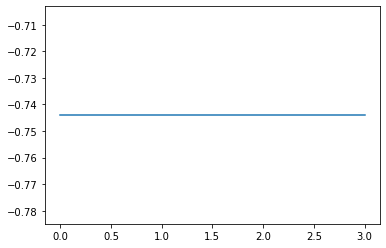

In [159]:
plt.plot(simWave)

In [154]:
integrationLength = 4
userDelay = 2000
path = 0
# Create expected wave input into QA input monitor
t1 = np.ones(10000, dtype=int)
t2 = np.ones(10000, dtype=int)*-1
simWave = np.concatenate([t1, t2])
simWave = simWave * 0.744

integrationLength = math.ceil(integrationLength/4)*4
sampleDelay = userDelay*8
simWave = simWave[sampleDelay:sampleDelay+integrationLength]
#weights = generateWeights(winType[0], wLen, amplitude)
weights = weights-(0.1*path)
if(len(weights) < integrationLength):
    weights = np.append(weights, np.zeros(integrationLength-len(weights)))
elif(len(simWave) < integrationLength):
    simWave = np.append(simWave, np.zeros(integrationLength-len(simWave)))
    
#weights = np.append(weights, np.zeros(len(simWave)-len(weights)))
np.sum(simWave*weights[:integrationLength])

-0.7277955072383059

In [153]:
integrationLength = 21
userDelay = 1
path = 0
# Create expected wave input into QA input monitor
t1 = np.ones(10000, dtype=int)
t2 = np.ones(10000, dtype=int)*-1
simWave = np.concatenate([t1, t2])
simWave = simWave * 0.744

integrationLength = math.ceil(integrationLength/4)*4
sampleDelay = userDelay*8
simWave = simWave[sampleDelay:sampleDelay+integrationLength]

weights = weights-(0.1*path)
if(len(weights) < integrationLength):
    weights = np.append(weights, np.zeros(integrationLength-len(weights)))
elif(len(simWave) < integrationLength):
    simWave = np.append(simWave, np.zeros(integrationLength-len(simWave)))

np.sum(simWave*weights[:integrationLength])

-0.7277955072383059

In [96]:
len(simWave) < integrationLength

False

In [ ]:
integrationLength = math.ceil(integrationLength/4)*4
sampleDelay = userDelay*8
simWave = simWave[sampleDelay:sampleDelay+integrationLength]

weights = weights-(0.1*path)
if(len(weights) < integrationLength):
    weights = np.append(weights, np.zeros(integrationLength-len(weights)))
elif(len(simWave) < integrationLength):
    simWave = np.append(simWave, np.zeros(integrationLength-len(simWave)))

return np.sum(simWave*weights[:integrationLength])

In [5]:
# Create weights
winType = ['boxcar', 'triang', 'hann', 'blackman', 'flattop', 'gaussian']
amplitude = np.random.rand()
wLen = np.random.randint(0, 1024)
weights = generateWeights(winType[0], wLen, amplitude)

In [6]:
# Create expected wave input into QA input monitor
t1 = np.ones(10000, dtype=int)
t2 = np.ones(10000, dtype=int)*-1
simWave = np.concatenate([t1, t2])
simWave = simWave * 0.744

In [ ]:
np.tra